# Object Detection with Faster R-CNN and VOC2012

This notebook explores the Faster R-CNN model, training it from scratch using the PASCAL VOC 2012 dataset.

In [ ]:
import torch
import torchvision
import os
import random
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import pathlib
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import torch.optim as optim
import torchvision.transforms.v2 as T
from torch import nn
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torch.cuda.amp import autocast
from torchmetrics.detection import MeanAveragePrecision

### Part 1: The Data

In [ ]:
# Download data
root_dir = "./data"
voc_dataset = torchvision.datasets.VOCDetection(
    root=root_dir,
    year="2012",
    image_set="train",
    download=True,
    transform=transforms.ToTensor()
)

In [ ]:
# Define custom VOC dataset class
class VOCDataset():
    def __init__(self, root_dir, image_set="train", transform=None):
        self.root_dir = root_dir
        self.image_set = image_set
        self.transform = transform
        self.image_dir = pathlib.Path(root_dir, "JPEGImages")
        self.annotation_dir = pathlib.Path(root_dir, "Annotations")
        self.split_file = pathlib.Path(root_dir, "ImageSets", "Main", f"{image_set}.txt")

        with open(self.split_file, "r") as f:
            self.image_ids = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = pathlib.Path(self.image_dir, f"{image_id}.jpg")
        ann_path = pathlib.Path(self.annotation_dir, f"{image_id}.xml")

        image = Image.open(image_path).convert("RGB")
        boxes, labels = self.parse_voc_xml(ann_path)

        if self.transform:
            # Apply transforms to both image and bounding boxes
            transformed = self.transform(image, boxes)
            image, boxes = transformed

        target = {"boxes": torch.tensor(boxes, dtype=torch.float32),
                  "labels": torch.tensor(labels, dtype=torch.int64)}
        
        return image, target

    def parse_voc_xml(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        boxes = []
        labels = []
        class_to_idx= {
            "aeroplane": 0, "bicycle": 1, "bird": 2, "boat": 3, "bottle": 4,
            "bus": 5, "car": 6, "cat": 7, "chair": 8, "cow": 9,
            "diningtable": 10, "dog": 11, "horse": 12, "motorbike": 13, "person": 14,
            "pottedplant": 15, "sheep": 16, "sofa": 17, "train": 18, "tvmonitor": 19
        }

        for obj in root.findall("object"):
            label = obj.find("name").text
            if label not in class_to_idx:
                continue
            labels.append(class_to_idx[label])
            
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
        
        return boxes, labels

In [ ]:
# Define transforms
train_trasnform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(p=0.5), # Random horizontal flip
    T.RandomVerticalFlip(p=0.2),   # Random vertical flip
    T.RandomRotation(degrees=(-30, 30)),
])

test_transform = T.Compose([
    T.ToTensor()
])

/home/kakudas/dev/jhu_en_705_643/venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# Initialize datasets
current_dir = pathlib.Path().resolve()
voc_path = pathlib.Path(current_dir, "data", "VOCdevkit", "VOC2012")

dataset = VOCDataset(voc_path, transform=test_transform)

In [7]:
# Create split for train and validation
dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Set appropriate transforms
train_dataset.transform = train_trasnform
val_dataset.transform = test_transform
test_dataset.transform = test_transform

In [ ]:
# Initialize dataloaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Load Faster R-CNN model
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=None)

# Get number of input features for the classifier
num_classes = 20
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Part 2: Train Functions

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cpu"):
    """
    Model training loop
    """
    model.train()
    size = len(dataloader.dataset)
    total_loss = 0

    for images, targets in tqdm(dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += losses.item()

    print(f"Avg Loss: {total_loss/len(dataloader)}")

In [ ]:
def test_loop(dataloader, model, device, metrics):
    model.eval()
    metric = MeanAveragePrecision(iou_thresholds=[0.5], class_metrics=True)
    
    total_predictions = []
    total_targets = []

    for images, targets in dataloader:
        with torch.no_grad():
            images = [img.to(device) for img in images]
            predictions = model(images)
            
        for prediction, target in zip(predictions, targets):
            total_predictions.append({
                "boxes" : prediction["boxes"].to(device),
                "scores" : prediction["scores"].to(device),
                "labels" : prediction["labels"].to(device),
            })

            total_targets.append({
                "boxes" : target["boxes"].to(device),
                "labels" : target["labels"].to(device),
            })
    
    metric.update(total_predictions, total_targets) 

    map_score = metric.compute()
    metrics.append(map_score)
    print(f"mAP: {map_score["map"]}")

    map_per_class = map_score["map_per_class"]
    mar_per_class = map_score["mar_100_per_class"]
    valid_map = map_per_class[map_per_class != -1]
    valid_mar = mar_per_class[mar_per_class != -1]

    precision = valid_map.mean().item() if len(valid_map) > 0 else 0.0
    recall = valid_mar.mean().item() if len(valid_mar) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1_score:.4f}")


### Part 3: Exploring Faster R-CNN

#### A: Anchor Boxes
Anchor boxes are used by the Faster R-CNN model to initialize all the potential bounding boxes for object detection. The model first takes the input image and passes it through a base convolutional network and outputs a feature map containing the extracted features. The model then assigns a pre-set number of anchor boxes to each location in the feature map with boxes of varying scales and aspect ratios. The allows the model to account for objects of different shapes and scales. The anchor boxes are defined as the center coordinates, width and height, and they serve as references that the model will refine as they are passed through the remaining modules.


#### B: Region Proposal Network
The first stage of the Faster R-CNN model is the Region Proposal Network (RPN) which takes in images as input and outputs a set of rectangular object proposals along with a prediction of whether it is a background or foreground object. The RPN first passes the input through convolutional layers to extract features from the image. The RPN then assigns anchor boxes to each feature location using a sliding window technique. At each sliding window location, multiple region proposals are predicted corresponding to preset scales and aspect ratios. By default the model is set to use 3 different scales and 3 different aspect ratios per location for a total of 9 anchor boxes per location. The region proposals are then passed to the second stage which performs object classification and further refines the boxes. The second stage uses regression loss to adjust the region proposals to better match the actual objects.

#### C: Prediction Refinement
The second stage of the model refines the anchor boxes by adjusting the x, y, width, and height by predicting the offsets relative to current values of the anchor box to the ground truth. The regression loss for refining the position and size only considers positive anchors, which are anchors that have the highest Intersection-over-Union (IoU) overlap with a ground truth box. The weighted difference of the center coordinates, width, and height between the anchor and ground truth are used as the bounding box regression, which further refines the region predictions.

#### D: Simultaneous Location Prediction and Object Classification
The Faster R-CNN model simultaneously classifies and refines the coordinates of each region proposal by minimizing an objective loss function that is the combination of the two losses, one for classification and one for regression. The classification loss is the log loss over two classes, object vs not object, which is combined with the regression loss discussed previously. Each feature is passed through two sibling fully-connected layers corresponding to the box-regression and box-classification. This sharing of convolutional layers allows the second stage to be implemented as a single model instead of two separate networks.

#### E: Filter Overlapping and Low-Confidence Predictions
With multiple region proposals assigned to every region, there will be a significant amount of both overlapping and false predictions. Faster R-CNN address these false detections using a scoring method and Non-Maximum Suppression (NMS). As mentioned previously, the RPN predicts an objectness score for each region proposal for whether it is an object of interest or just part of the background. This score is compared to a threshold and is only considered as a potential object if it passes the threshold as a positive anchor during training. The NMS is used at the end of the detection network to reduce redundant detections while maintaining unique predictions for detections with the highest confidence. NMS accomplishes this filtering by using the objectness score and selecting only the top-N anchor boxes to pass through. 

#### F: Intersection of Union (IoU) Calculations
To train the model and assess accuracy, the Intersection over Union (IoU) is used to measure the difference between the predicted region proposals and the ground truth bounding boxes. IoU is calculated as the ratio between the area of overlap and the area of union. The area of overlap is the intersection between the predicted and target bounding boxes, and the area of union is the total area covered by both bounding boxes minus the overlapping area. For a perfect prediction, the predicted box would have the same area as the target and have a union area equal to the area of the target, resulting in a IoU of 1. Alternatively, the greater difference in size and position will result in a lower IoU. 

The performance of object detection models like Faster R-CNN is commonly measured using the mean average precision (mAP), which is calculated by averaging the average precision (AP) across all object classes. Average precision is calculated as the area under the precision-recall curve. Precision is the ratio between true positives and the total number of detections, both true and false positives. Recall is the ratio between true positives and the total number of actual detections, both true positives and false negatives. To calculate the mAP of a specific IoU at a certain IoU threshold, the AP is calculated for each class is summed and divided by the N number of classes. The can be done with multiple IoU thresholds, demonstrating performance with both looser and stricter standards.

### Part 4: Training

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
# Cuda management
torch.cuda.init()
torch.cuda.synchronize()

In [15]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"CUDA Available: {torch.cuda.is_available()}")

CUDA Available: True


In [16]:
# Run training/test loops
metrics = []
num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch: [{epoch+1}/{num_epochs}]")
    train_loop(train_dataloader, model, criterion, optimizer, device)
    test_loop(test_dataloader, model, device, metrics)

Epoch: [1/20]


100%|██████████| 1144/1144 [05:07<00:00,  3.72it/s]


Avg Loss: 0.5553515622900291
mAP: 0.1185489147901535
Precision: 0.1185, Recall: 0.4246, F1-score: 0.1853
Epoch: [2/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.48935902274988746
mAP: 0.266341894865036
Precision: 0.2663, Recall: 0.6718, F1-score: 0.3815
Epoch: [3/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.439091099895068
mAP: 0.35021811723709106
Precision: 0.3502, Recall: 0.6846, F1-score: 0.4634
Epoch: [4/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.3987799159778686
mAP: 0.3697919547557831
Precision: 0.3698, Recall: 0.7239, F1-score: 0.4895
Epoch: [5/20]


100%|██████████| 1144/1144 [05:05<00:00,  3.74it/s]


Avg Loss: 0.3639063621004978
mAP: 0.4194656014442444
Precision: 0.4195, Recall: 0.6825, F1-score: 0.5196
Epoch: [6/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.32953825826476607
mAP: 0.4567162096500397
Precision: 0.4567, Recall: 0.7339, F1-score: 0.5630
Epoch: [7/20]


100%|██████████| 1144/1144 [05:05<00:00,  3.75it/s]


Avg Loss: 0.29558834322838934
mAP: 0.4687873125076294
Precision: 0.4688, Recall: 0.7416, F1-score: 0.5744
Epoch: [8/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.2691700824803406
mAP: 0.45528948307037354
Precision: 0.4553, Recall: 0.7067, F1-score: 0.5538
Epoch: [9/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.74it/s]


Avg Loss: 0.2481561359799617
mAP: 0.4843251407146454
Precision: 0.4843, Recall: 0.7215, F1-score: 0.5796
Epoch: [10/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.22694539420723497
mAP: 0.4979392886161804
Precision: 0.4979, Recall: 0.7297, F1-score: 0.5919
Epoch: [11/20]


100%|██████████| 1144/1144 [05:07<00:00,  3.71it/s]


Avg Loss: 0.20987762085168615
mAP: 0.5118812918663025
Precision: 0.5119, Recall: 0.7135, F1-score: 0.5961
Epoch: [12/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.19594120760806477
mAP: 0.5071231722831726
Precision: 0.5071, Recall: 0.6996, F1-score: 0.5880
Epoch: [13/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.18643138896498074
mAP: 0.5021362900733948
Precision: 0.5021, Recall: 0.6586, F1-score: 0.5698
Epoch: [14/20]


100%|██████████| 1144/1144 [05:05<00:00,  3.75it/s]


Avg Loss: 0.17588467566765376
mAP: 0.505657434463501
Precision: 0.5057, Recall: 0.6767, F1-score: 0.5788
Epoch: [15/20]


100%|██████████| 1144/1144 [05:07<00:00,  3.72it/s]


Avg Loss: 0.16495444901268017
mAP: 0.5132864117622375
Precision: 0.5133, Recall: 0.6505, F1-score: 0.5738
Epoch: [16/20]


100%|██████████| 1144/1144 [05:05<00:00,  3.75it/s]


Avg Loss: 0.15661640130504445
mAP: 0.5017418265342712
Precision: 0.5017, Recall: 0.6624, F1-score: 0.5710
Epoch: [17/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.15027825712304485
mAP: 0.5052393078804016
Precision: 0.5052, Recall: 0.6716, F1-score: 0.5767
Epoch: [18/20]


100%|██████████| 1144/1144 [05:06<00:00,  3.73it/s]


Avg Loss: 0.1422571285328196
mAP: 0.4946739375591278
Precision: 0.4947, Recall: 0.6418, F1-score: 0.5587
Epoch: [19/20]


100%|██████████| 1144/1144 [05:08<00:00,  3.71it/s]


Avg Loss: 0.13746413858965612
mAP: 0.5127379894256592
Precision: 0.5127, Recall: 0.6818, F1-score: 0.5853
Epoch: [20/20]


100%|██████████| 1144/1144 [05:07<00:00,  3.72it/s]


Avg Loss: 0.13073185183615846
mAP: 0.49007755517959595
Precision: 0.4901, Recall: 0.6559, F1-score: 0.5610


### Part 4: Validation & Results

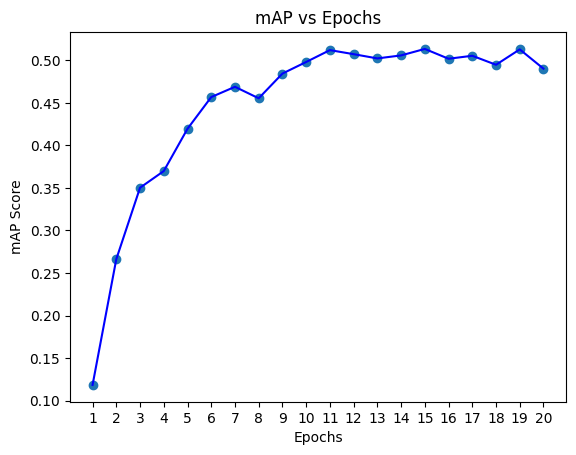

In [37]:
# Graph mAP over epochs
mAPs = [score["map"] for score in metrics]
epochs = [i+1 for i in range(num_epochs)]
plt.scatter(epochs, mAPs)
plt.plot(epochs, mAPs, color='blue', linestyle='-', label='Line')  
plt.xticks(epochs)
plt.title("mAP vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("mAP Score")
plt.show()

In [24]:
def draw_bboxes(image, targets, predictions):
    image = F.to_pil_image(image)
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(image)
    
    for box in targets["boxes"]:
        x_min, y_min, x_max, y_max = box.tolist()
        rect = patches.Rectangle(
            (x_min, y_min), x_max-x_min, y_max-y_min, 
            linewidth=2, edgecolor="green", facecolor="none"
        )
        ax.add_patch(rect)

    for box, score in zip(predictions["boxes"], predictions["scores"]):
        if score > 0.5:
            x_min, y_min, x_max, y_max = box.tolist()
            rect = patches.Rectangle(
                (x_min, y_min), x_max-x_min, y_max-y_min, 
                linewidth=2, edgecolor="red", facecolor="none"
            )
            ax.add_patch(rect)

    plt.axis("off")
    plt.show()

In [ ]:
def visualize_prediction(dataloader, model, device):
    random_batch = random.choice(list(dataloader))
    images, targets = random_batch

    with torch.no_grad():
        images = [img.to(device) for img in images]
        predictions = model(images)

    draw_bboxes(images[0], targets[0], predictions[0])


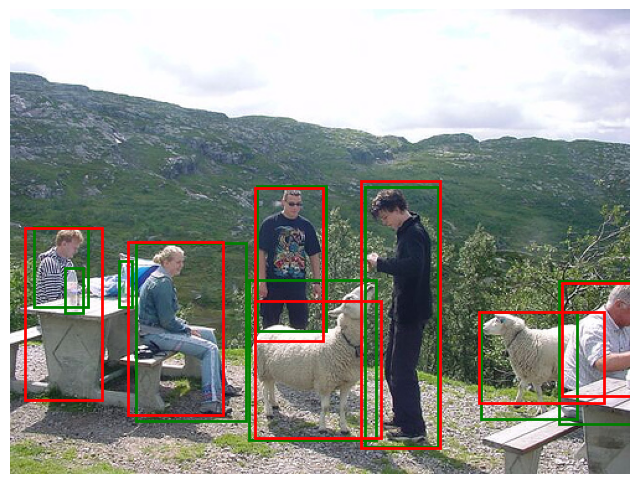

In [27]:
visualize_prediction(val_dataloader, model, device)

After training over 20 epochs, the model had a final mAP score of 0.5128. We are able to demonstrate Faster R-CNN's ability to accurately detect and classify objects. (Due CUDA memory issues, the validation output was lost.) 